# Image Processing With NumPy

Below are some simple image processing methods implemented using simple matrix processing methods in **NumPy**.

This notebook was part of a lab assignment submission for the course MTH00057 - Applied Maths and Statistics at VNUHCM - University of Science.

## Mục lục

* [Introduction](#c1)
* [Implementation](#c2)
    * [Brightness](#c21)
    * [Contrast](#c22)
    * [Color filters](#c23)
    * [Flip](#c24)
    * [Blur & Sharpen](#c25)
    * [Crop](#c26)
* [References](#c3)

## Introduction <a class="anchor" id="c1"></a>

Most digital image files are represented as 2-dimensional matrices of 'pixels'. Each pixel itself is an array of 3 integers ranging from 0 to 255, representing the intensity of the <font color="red"><b>R</b></font>ed, <font color="green"><b>G</b></font>reen and <font color="blue"><b>B</b></font>lue channels.

Some images have a fourth channel called the *alpha channel*, where a value of 0 is visualized as **black** and renders the pixel that underlies it completely **transparent**, while a value of 255 is visualized as **white** and renders the pixel that underlies it completely **opaque**. If an image consists of a single channel of blacks, grays and whites, it is considered a *grayscale* image.

All methods in this notebook are capable of processing images in grayscale and/or have alpha channels, with the alpha channel intact in the output:
- For grayscale images, each 'pixel' in the matrix is converted into an array of 3 elements to simulate an RGB image prior to processing, allowing it to be worked with like a regular 3-channel, RGB image.
- For images with an alpha channel, the alpha channel is separated before processing, and then 'reapplied' onto the proccessed RGB matrix to restore the original transparency of the pixels. This step is omitted for the blurring, sharpening, flipping and cropping methods, since they do not require the input array to be three-dimensional.

The processing methods in this notebook include:
1. Adjusting brightness
2. Adjusting contrast
3. Color filters (grayscale & sepia)
5. Flipping (on both axes)
6. Blurring
7. Sharpening
8. Cropping (box crop, circle crop and double-ellipse crop)

## Implementation <a class="anchor" id="c2"></a>

The libraries needed for this notebook include **NumPy** for processing the image matrix and **Matplotlib** to visualize the output.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The processing methods will be demonstrated on an image of a colorful macaw, converted to a 2D NumPy array.

((256, 256, 3), <matplotlib.image.AxesImage at 0x19e34a21430>)

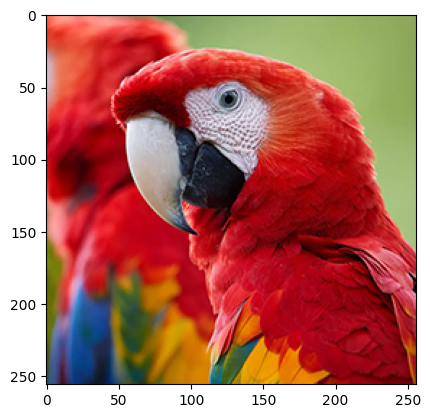

In [2]:
img = plt.imread('macaw.jpg')
orig = np.array(img)
orig.shape, plt.imshow(orig)

For certain Python libraries capable of image processing like **NumPy** and **OpenCV**, pixels might not be represented as integers from 0 to 255, but as floats from 0 to 1. Working with floats eliminates rounding errors if the array needs to undergo multiplication with floats or division. Therefore, the input image is divided by 255 and has its type converted to `float32` prior to processing for convenience.

In [3]:
orig = (np.array(orig) / 255).astype(np.float32)

orig

array([[[0.99607843, 0.43137255, 0.3372549 ],
        [0.98039216, 0.42745098, 0.31764707],
        [0.99215686, 0.4392157 , 0.33333334],
        ...,
        [0.5568628 , 0.6627451 , 0.36078432],
        [0.5529412 , 0.65882355, 0.35686275],
        [0.54901963, 0.654902  , 0.3529412 ]],

       [[0.99215686, 0.41960785, 0.32156864],
        [0.9882353 , 0.42352942, 0.31764707],
        [0.99607843, 0.43137255, 0.32941177],
        ...,
        [0.5529412 , 0.65882355, 0.35686275],
        [0.5529412 , 0.65882355, 0.35686275],
        [0.54901963, 0.654902  , 0.3529412 ]],

       [[1.        , 0.40784314, 0.31764707],
        [1.        , 0.4117647 , 0.3137255 ],
        [0.99607843, 0.42352942, 0.33333334],
        ...,
        [0.5529412 , 0.65882355, 0.35686275],
        [0.5529412 , 0.65882355, 0.35686275],
        [0.54901963, 0.654902  , 0.3529412 ]],

       ...,

       [[0.1764706 , 0.31764707, 0.27058825],
        [0.17254902, 0.32156864, 0.35686275],
        [0.2       , 0

Being a JPG file, the input image does not have an alpha channel. In order to handle images with one, let's define a helper method to split the alpha channel from the image and return it, along with the RGB matrix:

In [4]:
def split_alpha(img):
    alpha = img[:, :, 3]
    img = img[:, :, :3]
    return img, alpha

Let's also define a method to neatly present images side-by-side, to compare our befores and afters: 

In [33]:
def visualize(images, titles=[]):
    fig = plt.figure(figsize=(len(images) * 2.5, 2.5))
    # plot the images
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1)
        plt.imshow(images[i], cmap='gray', vmin=0, vmax=1)
        if (titles):
            plt.title(titles[i])
    fig.tight_layout()

#### Brightness <a class="anchor" id="c21"></a>

To adjust an image's brightness, we can add or subtract a specific value from each pixel. The `brightness` method takes the pixel matrix and `amount` (an integer within  $[-100, 100]$) as parameters. `amount` represents the **percentage** of the output image's brightness compared to the input image. By multiplying the input matrix with `amount` and add the resulting matrix to the original matrix, then clipping the pixels' value range to $[0, 1]$, we can effectively alter its brightness.

In [31]:
def brightness(img, amount=50):
    # grayscale images only have 2 dimensions
    # manually add a third axis if the image is grayscale
    if len(img.shape) == 2:
        img = img[..., np.newaxis]
    # extract the alpha channel if it exists
    if img.shape[2] > 3:
        rgb, alpha = split_alpha(img)
    # otherwise, just duplicate the original image
    else:
        rgb = img.copy()
    output = rgb + (rgb * (amount / 100))
    output = np.clip(output, 0., 1.) 
    # if the original image has an alpha channel, stack it back on
    if img.shape[2] > 3:
        return np.dstack((output, alpha))
    
    return output

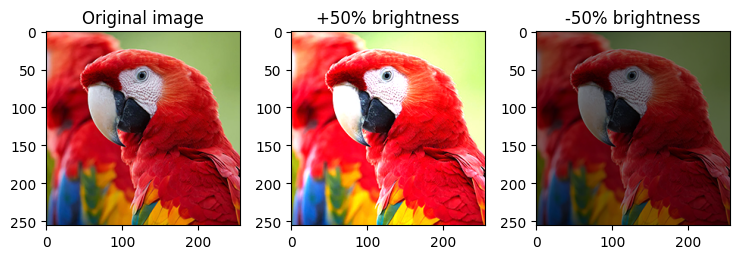

In [34]:
brightened = brightness(orig, 50)
darkened = brightness(orig, -50)
visualize([orig, brightened, darkened], ['Original image', '+50% brightness', '-50% brightness'])

#### Contrast <a class="anchor" id="c22"></a>

To adjust an image's contrast, we 'stretch' or 'compress' the value range of each pixel. In other words, to increase the contrast of an image, we bring the 'bright' pixels' values closer to $1$ and the 'dark' pixels' values closer to $0$ and vice versa. Exponential functions are capable of this operation, in which an exponent less than $1$ will increase the contrast and vice versa.

Adjusting an image's contrast by passing the matrix through an exponential function only affects the pixels whose values are at the extreme ends of the range, so *midtones*, whose values are around $0.5$, are virtually unaffected. To counter this, all the pixels will have their value shifted to the left (along the $x$ axis) by $0.5$ prior to processing. However, this introduces negative values that cannot be plugged into exponential functions. We can process the absolute value of these pixels before multiplying them with the corresponding value from the *sign array* return by **NumPy**'s `sign` method. The pixels are then shifted back to ensure the value range remains $[0,1]$.

Further reading on how this work is included in the [References](#c3) section.

The `contrast` method takes the pixel matrix and `amount` (an integer within  $[-100, 100]$) as parameters. `amount` represents the **percentage** of the output image's contrast compared to the input image. It calculates the contrast `factor` using the formula $$factor = \frac{100 + amount}{100}$$ The left-shifted matrix is then lifted to the power of $\frac{1}{factor}$ and shifted back to the right before returning.

In [8]:
def contrast(img, amount=100):
    if len(img.shape) == 2:
        img = img[..., np.newaxis]
    if img.shape[2] > 3:
            rgb, alpha = split_alpha(img)
    else:
        rgb = img.copy()
    # calculate contrast factor
    factor = 1 + (amount / 100)
    # 1 / factor is invalid if factor is 0 (or amount is -100)
    # returns a gray image
    if factor == 0:
        return np.full_like(rgb, 0.5)
    # shifting midtones (values ~ 0.5) towards 0 to drastically change midtones
    shifted = (rgb - 0.5) * 2
    # after shifting, shadows now have negative values
    # obtain their absolute value to raise them to the power of 1 / factor
    # then retrieve their original sìgns by multiplying with the sign array
    output = np.abs(shifted) ** (1 / factor) * np.sign(shifted)
    # recenter the midtones and shifting all shadows to non-negative values
    output = (output / 2) + 0.5
    if img.shape[2] > 3:
        return np.dstack((output, alpha))
    return output

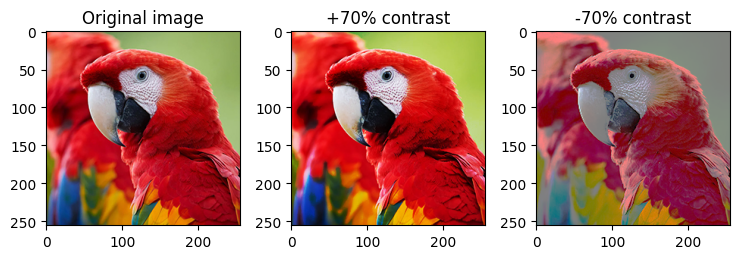

In [35]:
hi_contrast = contrast(orig, 70)
lo_contrast = contrast(orig, -70)
visualize([orig, hi_contrast, lo_contrast], ['Original image', '+70% contrast', '-70% contrast'])

#### Color filters <a class="anchor" id="c23"></a>

##### Grayscale filter

The CIE 1931 color space defines the formula to convert a pixel with linear RGB values to a grayscale pixel such that its linear luminance stays the same as follows:

$$Y_{linear} = 0.2126R_{linear} + 0.7152G_{linear} + 0.7222B_{linear}$$

The `desaturate` method performs a matrix multiplication for a matrix consisting of the above coefficients and the pixel matrix of the input image. The resulting matrix will not have values exceeding the $[0, 1]$ range, since the sum of the coefficients is $1$.

If the input image has an alpha channel, the method will stack the resulting matrix three times before laying the alpha channel on top (an image with an alpha channel must have four channels). Otherwise, the method returns a single-channel image.

In [10]:
def desaturate(img):
    if len(img.shape) == 2:
        img = img[..., np.newaxis]
    if img.shape[2] > 3:
        rgb, alpha = split_alpha(img)
    else:
        rgb = img.copy()
    # make a weights matrix based on the CIE 1931 linear luminance
    weights = np.array([0.2126, 0.7152, 0.0722])
    output = np.matmul(rgb[...,:3], weights)
    # in order to retain the alpha channel, image must have 3 color channels
    # stack the gray channel 3 times
    if img.shape[2] > 3:
        return np.dstack((output, output, output, alpha))
    return output

##### Sepia filter

The formulae to calculate new RGB values for each sepia-filtered pixel are as follows:
$$R_{sepia} = 0.393R + 0.769G + 0.189B \\
  B_{sepia} = 0.349R + 0.686G + 0.168B \\
  G_{sepia} = 0.272R + 0.534G + 0.131B$$

The `sepia` method performs a matrix multiplication for a matrix consisting of the above coefficients and the pixel matrix of the input image. The resulting matrix is then clipped to range before being returned.

In [11]:
def sepia(img):
    if len(img.shape) == 2:
        img = img[..., np.newaxis]
    if img.shape[2] > 3:
        rgb, alpha = split_alpha(img)
    else:
        rgb = img.copy()
    # new_color = R_weight * R + G_weight * G + B_weight * B
    sep_filter = np.array([[.393, .769, .189],
                           [.349, .686, .168],
                           [.272, .534, .131]])
    # transpose the filter to align red weights with the red channel, etc.
    output = np.matmul(rgb[...,:3], sep_filter.T)
    output = np.clip(output, 0., 1.)
    # stack the alpha channel back on if it exists
    if img.shape[2] > 3:
        return np.dstack((output, alpha))
    return output

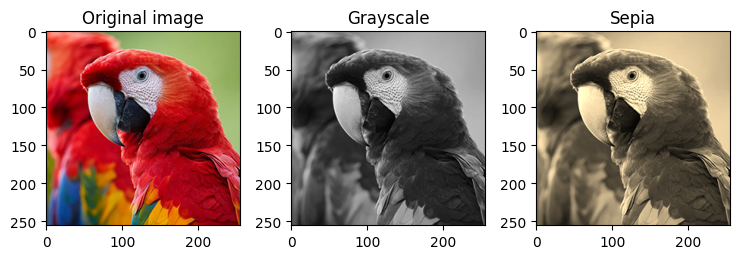

In [36]:
img_gray = desaturate(orig)
img_sepia = sepia(orig)
visualize([orig, img_gray, img_sepia], ['Original image', 'Grayscale', 'Sepia'])

#### Flip <a class="anchor" id="c24"></a>

Using **NumPy**'s array slicing, the `flip` method simply returns a flipped array by indexing it with `::-1` on the axis to be flipped on.

In [13]:
def flip(img, mode='h'):
    if mode == 'v':
        return img[::-1, :]
    else:
        return img[:, ::-1]

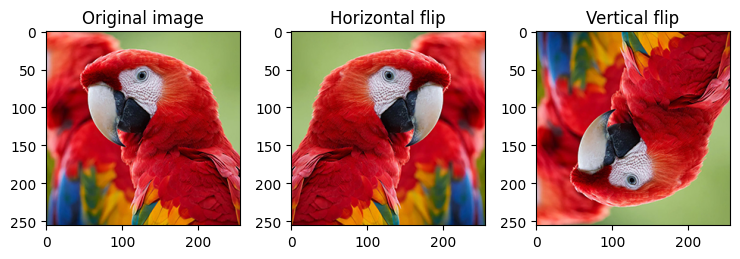

In [37]:
flip_h = flip(orig, 'h')
flip_v = flip(orig, 'v')
visualize([orig, flip_h, flip_v], ['Original image', 'Horizontal flip', 'Vertical flip'])

#### Blur & Sharpen <a class="anchor" id="c25"></a>

To blur or sharpen an image, we convolve the pixel matrix with a *kernel*. A kernel is usually an $N*N$ matrix, in which $N$ is an odd number (so that the kernel has a center cell). Convolution works by 'sliding' the kernel over each pixel, multiplying each cell in the kernel with its underlying pixel, then adding together all the products. The final result is the new value of the pixel underlying the kernel's center.

Further reading on kernels and convolution is included in the [References](#c3) section.

##### The `convolve` method

The `convolve` method convolves the pixel matrix with a given kernel. Since an image usually consists of multiple channels (multiple two-dimensional matrices), the method will execute on each channel separately.

Since convolution happens on the pixel underlying the center of a kernal, the pixel matrix must be padded with duplicates of edge pixels so that the kernel still has values to multiply with at the edges and corners. For an $N*N$ kernel, the thickness of the padding is determined by the formula $$padding = \frac{N-1}{2}$$

The method then calculates the *steps* needed to slide a kernel along one axis of the matrix from start to end before performing convolution on a flattened, one-dimensional array of pixels before reshaping it into a proper image array and clipping the value of each pixel to range.

In [47]:
def convolve(img, kernel):
    # create a 3rd axis if the image is grayscale
    if len(img.shape) == 2:
        img = img[..., np.newaxis]
    else:
        img = img.copy()
    # pad the original image with pixels so that the kernel still works with corner and edge pixels
    # mode='edge' so that edge pixels will be repeated
    padding = int((kernel.shape[0] - 1) / 2)
    padded = np.pad(img, ((padding, padding), (padding, padding), (0, 0)), mode='edge')
    (h_i, w_i, c_i) = padded.shape
    (h_k, w_k) = kernel.shape
    # calculate possible no. of kernel steps in both directions
    v_steps = h_i - h_k + 1
    h_steps = w_i - w_k + 1
    # initialize the output matrix
    output = np.zeros(img.shape, dtype=np.float32)
    # keeping track of output pixels' coordinates is a pain
    # flatten the output array
    output_tmp = output.reshape((img.shape[0] * img.shape[1], img.shape[2]))
    index = 0  # index of the pixel being processed
    for i in range(v_steps):
        for j in range(h_steps):
            # loop over all channels
            for c in range(c_i):
                sub_matrix = padded[i : i + h_k, j : j + w_k, c]
                output_tmp[index, c] = np.sum(sub_matrix * kernel)
            index += 1
    output = output_tmp.reshape(img.shape)
    output = np.clip(output, 0., 1.)
    return output

There are multiple types of blurring kernels, thus multiple methods of blurring. This notebook implements a simplified version of the **Gaussian blur** method.

##### Gaussian blur

The `gaussian_blur` method uses a kernel whose cells' values follow a Gaussian distribution. For the sake of simplicity, this implementation of Gaussian blur only uses a kernel that follows the bell-curve distribution. It takes the pixel matrix and a `sigma` value as the parameter.

The optimal size parameter $N$ with which to construct an $N*N$ matrix is determined by the formula $N = 2 * \lceil 3 + \sigma \rceil + 1$. The reason for this is to ensure that the kernel is large enough to keep the convolved value of each pixel relatively high, thus preserving the brightness of the image. Otherwise, a small kernel will darken the image when blurred with a high `sigma` value.

The method initializes an axis of $x$ values such that $x \in [-N, N]$, before plugging them into the formula $-\frac{x^2}{2\sigma^2}$ to create an axis with values conforming to the bell-curve distribution. The cross product of this axis with itself is the blurring kernel. Each cell in the kernel will then be divided by the sum of all the values in the kernel to bring the sum down to 1 (so that the convolved value of a pixel will not exceed 1). Finally, the method calls `convolve` on the pixel matrix using the newly made kernel before returning the result.

Since `convole` works on each channel individually and works just fine with the alpha channel, there is no need to remove it from the image before processing.

In [66]:
def gaussian_blur(img, sigma=2.5):
    # calculate the optimal kernel size for given sigma
    n = int(2 * np.ceil(3 * sigma) + 1)
    # generate an x-axis to plug into function
    gauss_1d = np.linspace(-(n - 1) / 2., (n - 1) / 2., n)
    # f(x) = e^-(x^2 / 2*(sigma^2)) is already enough for a bell-curve
    gauss_1d = np.exp(-0.5 * (gauss_1d ** 2) / sigma ** 2)
    # outer product of 2 1-d matrices is a 2-d matrix
    kernel = np.outer(gauss_1d, gauss_1d)
    # normalize the total weight to 1
    kernel = kernel / np.sum(kernel)
    return convolve(img, kernel)

##### Sharpen

We will use an existing weights matrix as our base to create a sharpening kernel: $$\begin{bmatrix}
                                                                                    0 & -1 & 0 \\
                                                                                    -1 & 4 & -1 \\
                                                                                    0 & -1 & 0
                                                                                    \end{bmatrix}$$

The kernel will be calculated using the formula
$$\begin{bmatrix}
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0
\end{bmatrix} + \begin{bmatrix}
0 & -1 & 0 \\
-1 & 4 & -1 \\
0 & -1 & 0
\end{bmatrix} * amount$$

in which $amount$ determines the intensity of the sharpening process. The method then calls `convolve` on the pixel matrix using the newly made kernel.

The optimal value for $amount$ falls within $[0, 5]$.

In [67]:
def sharpen(img, amount=2.5):
    # kernel = identity_matrix + (weights_matrix * amount)
    kernel = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]) \
           + np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]) * amount
    output = convolve(img, kernel)
    return output

However, higher `amount` values introduce high levels of noise in the sharpened image. Another sharpening method that yields a less noisy image is *unsharp masking*. By subtracting a blurred version of an image from the image itself, we're left with an image consisting of only the **edges** of the subject(s). The edge-only image is also known as a *high-pass filter* and this subtracting process can be considered a simple edge-detection algorithm. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


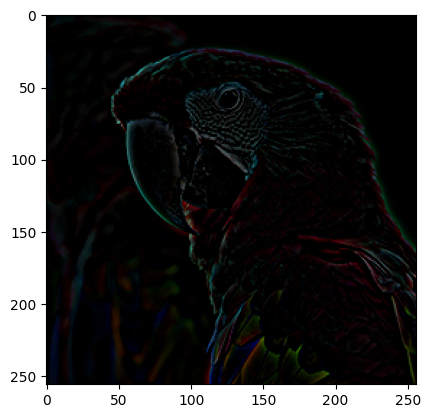

In [71]:
blurry = gaussian_blur(orig, 3)
edges = orig - blurry
plt.imshow(edges, cmap='gray')

This can then be applied onto the original image to increase the contrast between both sides of the edges, giving the image a 'sharpened' appearance.

In [53]:
def unsharp(img, sigma=2.5):
    img_blurred = gaussian_blur(img, sigma)
    # output = img + img - img_blurred
    output = 2 * img - img_blurred
    output = np.clip(output, 0., 1.)
    return output

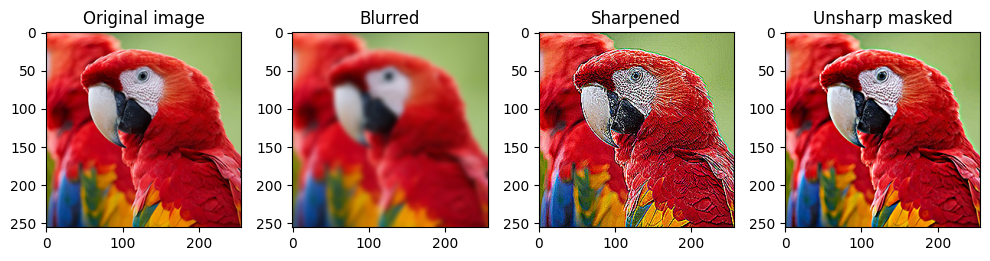

In [39]:
blurred = gaussian_blur(orig, 3)
sharpened = sharpen(orig, 3)
unsharped = unsharp(orig, 3)
visualize([orig, blurred, sharpened, unsharped], ['Original image', 'Blurred', 'Sharpened', 'Unsharp masked'])

#### Crop <a class="anchor" id="c316"></a>

##### From-center rectangular crop

The `crop_from_center` method takes the tuple $(outputHeight, outputWidth)$ as a parameter to determine the dimensions of the cropped image, then calculates the starting coordinates for the crop using the formulae
$$ x_{start} = \frac{width_{original} - width_{cropped}}{2}, \quad
   y_{start} = \frac{height_{original} - height_{cropped}}{2} $$
   
Then, using array slicing, it removes the bordering pixels before returning the result.

In [55]:
def crop_from_center(img, dimensions=(300, 200)):
    img = img.copy()
    (orig_h, orig_w, _) = img.shape
    (crop_h, crop_w) = dimensions
    if crop_h > orig_h or crop_h < 0 or crop_w > orig_w or crop_w < 0:
        return ('Invalid cropped size.')
    start_x = (orig_w - crop_w) // 2
    start_y = (orig_h - crop_h) // 2 
    return img[start_y:start_y + crop_h, start_x:start_x + crop_w]

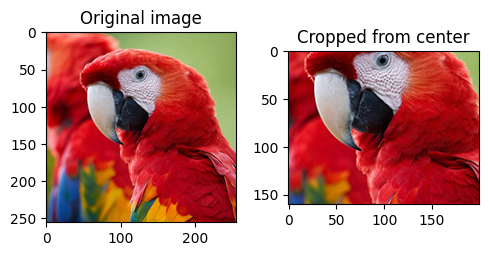

In [57]:
center_cropped = crop_from_center(orig, (160, 200))
visualize([orig, center_cropped], ['Original image', 'Cropped from center'])

##### Circular crop

To perform a circular crop, we can add a circular *alpha mask*—an alpha channel with black pixels overlaying parts of the image we want to hide, and white over the parts we want visible—over the three-channel image.

Create a square *mesh grid* with the circle's diameter as its edge length using **NumPy**'s `mgrid`. If we plug the `x` and `y` values that `mgrid` returns into a circle function
$$circle = (x - r)^2 + (y - r)^2 \le r^2$$
in which $r = diameter / 2$, we will get a matrix of booleans with the True (or 1) values forming a circle. This is the alpha mask.

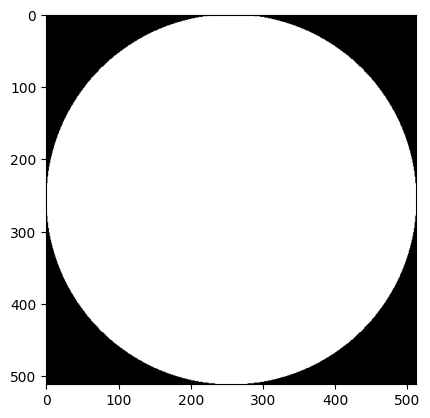

In [72]:
diameter = 512
x, y = np.mgrid[:diameter, :diameter]
circle = ((x - diameter/2)**2 + (y - diameter/2)**2) <= ((diameter/2)**2)
plt.imshow(circle, cmap='gray')

The `circular_crop` method creates an alpha mask whose diameter is the input image's short edge, then lays the mask on top of the pixel matrix before returning. If the input image already has an alpha channel, the method multiplies it with the alpha mask before overlaying it.

In [75]:
def circular_crop(img):
    if img.shape[0] != img.shape[1]:
        diameter = min(img.shape[0], img.shape[1])
        img = crop_from_center(img, (diameter, diameter))
    else:
        diameter = img.shape[0]
        img = img.copy()
    # create the alpha mask
    x, y = np.mgrid[:diameter, :diameter]
    circle = ((x - diameter/2)**2 + (y - diameter/2)**2) <= ((diameter/2)**2)
    # check if the image already has an alpha channel
    if img.shape[2] > 3:
        output, alpha = split_alpha(img)
        alpha = circle.astype(np.float32) * alpha
        return np.dstack((output, alpha.astype(np.float32)))
    return np.dstack((img, circle))

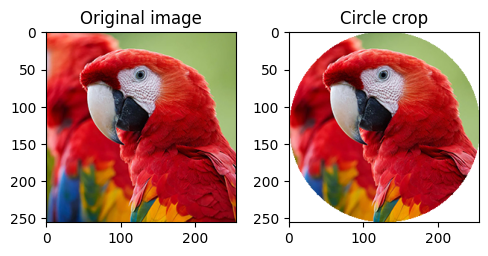

In [76]:
circular_cropped = circular_crop(orig)
visualize([orig, circular_cropped], ['Original image', 'Circle crop'])

##### Double-ellipse crop

Similar to `circular_crop`, the `double_ellipse_crop` method creates an alpha mask using the ellipse function
$$ellipse = \frac{(x - a)^2}{a^2} + \frac{(y - b)^2}{b^2} - \frac{2(x - a)(y - b)m}{ab} \le 1 - m^2$$
in which $a$ and $b$ are half of the image's width and height, respectively. This particular function draws an ellipse that lies parallel to the diagonal of a rectangle the same size as the image, and its width is dependent on the parameter $m\ (-1 \le m \le 1)$. By replacing $m$ in $\frac{2(x - a)(y - b)m}{ab}$ with $-m$, we can make the ellipse parallel to the opposite diagonal.

Using bit-wise OR on these two ellipses, we get the desired alpha mask.

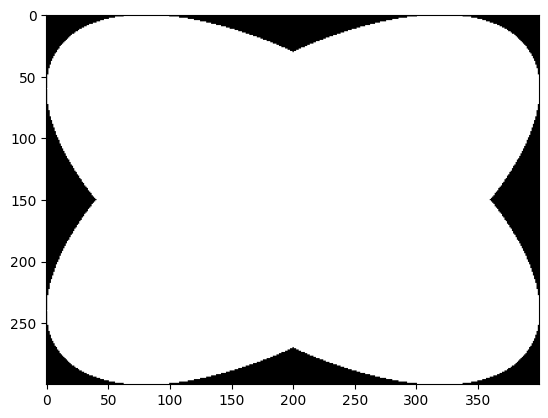

In [77]:
# set up the parameters
(h, w) = (300, 400)
(b, a) = (h // 2, w // 2)
m = 0.6
# create the alpha mask
y, x = np.mgrid[:h, :w]
ellipse1 = ((x-a)/a)**2 + ((y-b)/b)**2 - (2*(x-a)*(y-b)*m) / (a*b) <= 1 - m**2
ellipse2 = ((x-a)/a)**2 + ((y-b)/b)**2 - (2*(x-a)*(y-b)*-m) / (a*b) <= 1 - m**2
plt.imshow(ellipse1 | ellipse2, cmap='gray')

In [78]:
def double_ellipse_crop(img, ellipse_width=0.6):
    # set up the parameters
    (h, w, _) = img.shape
    (b, a) = (h // 2, w // 2)
    # create the alpha mask
    y, x = np.mgrid[:h, :w]
    ellipse1 = ((x-a)/a)**2 + ((y-b)/b)**2 - (2*(x-a)*(y-b)*ellipse_width) / (a*b) <= 1 - ellipse_width**2
    ellipse2 = ((x-a)/a)**2 + ((y-b)/b)**2 - (2*(x-a)*(y-b)*-ellipse_width) / (a*b) <= 1 - ellipse_width**2
    mask = ellipse1 | ellipse2
    # check if the image already has an alpha channel
    if img.shape[2] > 3:
        output, alpha = split_alpha(img)
        alpha = mask.astype(np.float32) * alpha
        return np.dstack((output, alpha.astype(np.float32)))
    return np.dstack((img.copy(), mask))

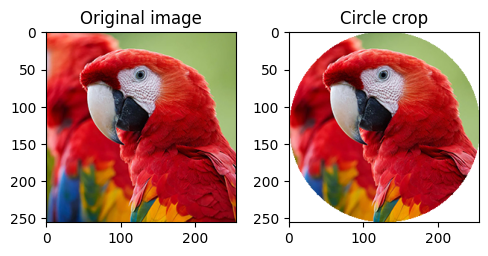

In [79]:
ellipse_cropped = double_ellipse_crop(orig)
visualize([orig, ellipse_cropped], ['Original image', 'Double-ellipse crop'])

## References <a class="anchor" id="c3"></a>

1. Yedhu Krishnan (2022), *Image Manipulation in Python*, https://yedhu.medium.com/image-manipulation-in-python-98db79cc0c1

2. Nick Eubank n.d., *Matrices as Images*, https://www.practicaldatascience.org/html/25_images_as_matrices.html

3. eickenberg (2014), reply to *Using numpy to apply a sepia effect to a 3D array*, StackOverflow, https://stackoverflow.com/a/23806249

4. Article *Kernel (Image Processing)*, Wikipedia, https://en.wikipedia.org/wiki/Kernel_(image_processing)

5. Rohit Krishna (2023), *Coding: Gaussian Blur Algorithm from scratch in Python.*, https://medium.com/@rohit-krishna/coding-gaussian-blur-operation-from-scratch-in-python-f5a9af0a0c0f

6. Cris Luengo (2020), comment on reply to *Optimal sigma for Gaussian filtering of an image?*, StackOverflow, https://stackoverflow.com/a/62002971

7. Junuxx (2012), reply to *Creating Gaussian filter of required length in python*, StackOverflow, https://stackoverflow.com/a/11209560

8. Hypergeometrix (2017), reply to *Ellipse in a Rectangle*, Mathematics Stack Exchange, https://math.stackexchange.com/a/2308342